<a href="https://colab.research.google.com/github/HyeonhoonLee/TSA_pandas/blob/master/11_ARIMA_and_Rolling_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA and Rolling Forecast



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## 데이터 읽기와 포매팅

데이터는 3년치 월별 샴푸 판매량으로 [Data Market](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line) 에서 다운로드 받아 저장한 CSV 파일을 사용합니다.

In [3]:
# 기존의 데이터 로딩 방식으로 해본다.(date parsing 사용)
shampoo = pd.read_csv('/content/drive/My Drive/Tacademy/TSA_pandas/data/sales-of-shampoo.csv', index_col='Month', parse_dates=True
                      )

In [4]:
# index가 일반적인 Datetime 형식이 아닌 것을 알 수 있다.
# 즉, Date parsing이 제대로 되지 않는 것을 확인할 수 있다.
shampoo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 1-01 to 3-12
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales of shampoo  36 non-null     float64
dtypes: float64(1)
memory usage: 576.0+ bytes


In [5]:
# 위의 내용을 한번 더 확인. 
shampoo.head()

,Sales of shampoo
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


In [6]:
# Month 칼럼을 읽기 위한 파서
def dateparser(x):
    return datetime.strptime('190'+x, "%Y-%m")
#    "1-01" => "1901-01"
## .strptime: string to datetime object
## .strftime: datetime to string

In [7]:
shampoo = pd.read_csv('/content/drive/My Drive/Tacademy/TSA_pandas/data/sales-of-shampoo.csv', index_col='Month', parse_dates=True, date_parser=dateparser)

In [8]:
shampoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1901-01-01 to 1903-12-01
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales of shampoo  36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes


In [9]:
shampoo.head()

,Sales of shampoo
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


## Visualize the data

pandas 내장 플로팅 함수들로 시계열 데이터를 시각화 해봅니다. 뚜렷한 트랜드를 보이는 반면 시즌 패턴은 보이지 않습니다.

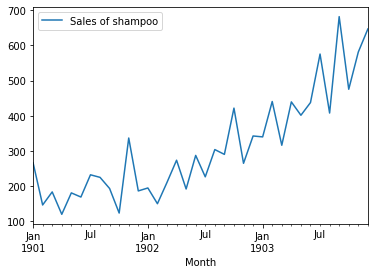

In [10]:
shampoo.plot()

## Testing for Stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else:
        print('Non-Stationary {}'.format(result[1]))

In [13]:
adf_check(shampoo['Sales of shampoo'])

Non-Stationary 1.0


테스트 결과 데이터가 stationary 특성을 보이지 않고 있음이 확인됩니다.

## Differencing

시계열 데이터에 대한 1차(first) difference 는 다음 스탭으로의 한 차원(시간단위) 만큼의 변화값의 series 입니다. pandas 를 이용하면 아주 differencing 할 수 있습니다. 1차, 2차 등 differencing 을 시도해보고 stationary 한 차원을 찾습니다.

#### First Difference

In [14]:
shampoo['1st diff'] = shampoo['Sales of shampoo'] - shampoo['Sales of shampoo'].shift(1)

In [15]:
adf_check(shampoo['1st diff'].dropna())

Stationary 1.7998574141687034e-10


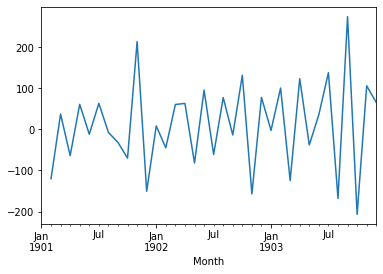

In [16]:
shampoo['1st diff'].plot()

#### Second Difference

In [17]:
shampoo['2nd diff'] = shampoo['1st diff'] - shampoo['1st diff'].shift()

In [18]:
adf_check(shampoo['2nd diff'].dropna())

Stationary 0.003906334939660387


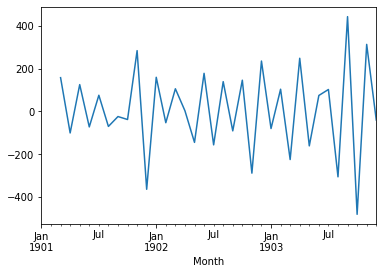

In [19]:
shampoo['2nd diff'].plot()

## Autocorrelation and Partial Autocorrelation Plots

In [ ]:
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

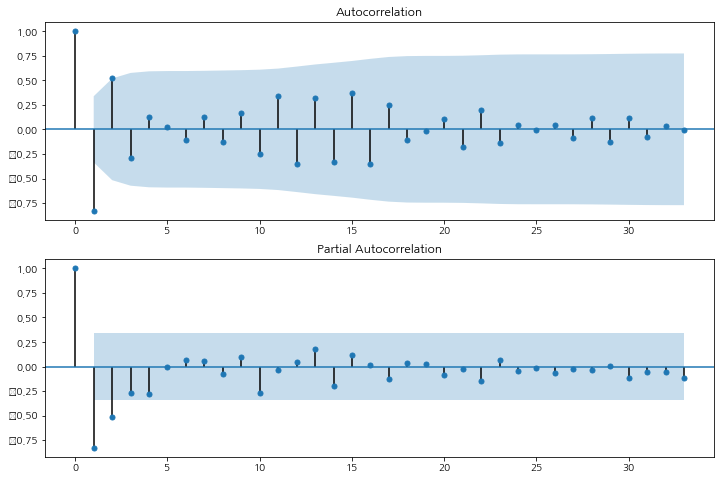

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(shampoo['2nd diff'].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(shampoo['2nd diff'].dropna(), ax=ax2, method='ywm')

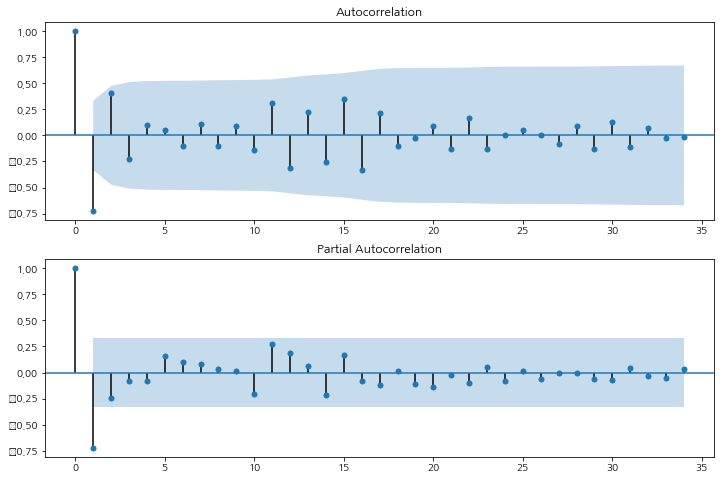

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(shampoo['1st diff'].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(shampoo['1st diff'].dropna(), ax=ax2, method='ywm')

PACF 와 ACF 에서 각각 lag 1 에 대해 강한 상관관계를 보이고 있습니다.

In [21]:
# Seasonality가 없으므로 SARIMA가 아닌 ARIMA를 import
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model = ARIMA(shampoo['Sales of shampoo'], order=(1,1,1), freq='MS')
model_fit = model.fit(disp=0)

In [ ]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.Sales of shampoo   No. Observations:                   35
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -197.233
Method:                       css-mle   S.D. of innovations             66.625
Date:                Thu, 31 Jan 2019   AIC                            402.467
Time:                        19:34:34   BIC                            408.688
Sample:                    02-01-1901   HQIC                           404.614
                         - 12-01-1903                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       12.0965      3.651      3.313      0.002       4.940      19.253
ar.L1.D.Sales of shampoo    -0.5674      0.161     -3.526      0.001      -0.883      -0.

일단 residual error 에 대해 line plot 을 그려고보 모델에 의해 파악되지 않은 트랜드 정보가 있는지 확인합니다.

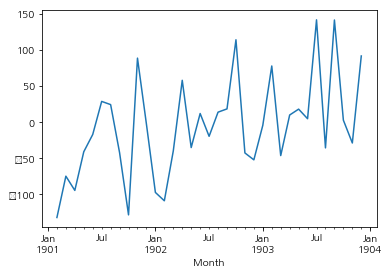

In [ ]:
# plot residual errors
model_fit.resid.plot()

다음으로 residual error 에 대한 density plot 을 그리고 정규분포에 가까운지 확인합니다.

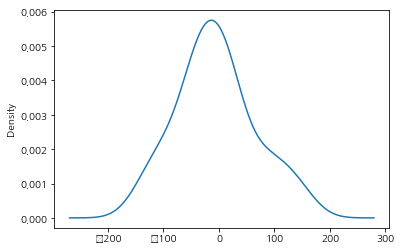

In [ ]:
model_fit.resid.plot(kind='kde')

In [ ]:
model_fit.resid.describe()

count     35.000000
mean      -5.505160
std       69.978598
min     -132.196527
25%      -42.395612
50%       -4.181400
75%       21.540075
max      142.155114
dtype: float64

## GridSearch
AIC 를 기준으로 최적의 p,d,q 파라메터를 찾습니다.

In [22]:
import itertools

p = range(0,5)
d = range(1,3)
q = range(0,5)

pdq = list(itertools.product(p, d, q))

In [23]:
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 2, 4),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 2, 0),
 (4, 2, 1),
 (4, 2, 2),
 (4, 2, 3),
 (4, 2, 4)]

In [24]:
# Loop문을 이용하여 AIC가 최솟값이 되는 param을 찾는다.
aic_params = []

for param in pdq:
    try:
        mod = ARIMA(shampoo['Sales of shampoo'], order=param)
        results = mod.fit(disp=0)
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        aic_params.append((results.aic, param,))
    except:
        pass

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

ARIMA(0, 1, 0) - AIC:430.87311187552797
ARIMA(0, 1, 1) - AIC:409.0126622411764
ARIMA(0, 2, 0) - AIC:461.1578257086931
ARIMA(0, 2, 1) - AIC:424.58251672548465
ARIMA(1, 1, 0) - AIC:406.02228959249555
ARIMA(1, 1, 1) - AIC:402.46665241798223
ARIMA(1, 1, 2) - AIC:401.52479437982333


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 3) - AIC:403.52417287494245
ARIMA(1, 2, 0) - AIC:423.9000860378354


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

ARIMA(2, 1, 0) - AIC:403.62756411671035
ARIMA(2, 1, 1) - AIC:404.2862142330706
ARIMA(2, 2, 0) - AIC:412.999382497039


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

ARIMA(2, 2, 1) - AIC:396.6526254968869
ARIMA(2, 2, 3) - AIC:389.6834254541216
ARIMA(3, 1, 0) - AIC:404.69245918163824


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

ARIMA(3, 1, 1) - AIC:406.13954439295287


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

ARIMA(3, 1, 4) - AIC:406.67979078476526
ARIMA(3, 2, 0) - AIC:410.9109265845824


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 2, 1) - AIC:396.3062365835407


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 2, 3) - AIC:406.1049294516596
ARIMA(4, 1, 0) - AIC:404.7867685567443


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

ARIMA(4, 1, 1) - AIC:406.579640361222


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 2) - AIC:400.23077953860263


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 3) - AIC:400.65677258684343


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 4) - AIC:406.38084843592287
ARIMA(4, 2, 0) - AIC:403.9482289506921
ARIMA(4, 2, 1) - AIC:393.15407509446567


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(4, 2, 3) - AIC:402.57184320722024


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [25]:
# ARIMA(4,2,1)
model = ARIMA(shampoo['Sales of shampoo'], order=(4,2,1))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARIMA Model Results                              
Dep. Variable:     D2.Sales of shampoo   No. Observations:                   34
Model:                  ARIMA(4, 2, 1)   Log Likelihood                -189.577
Method:                        css-mle   S.D. of innovations             56.216
Date:                 Fri, 11 Sep 2020   AIC                            393.154
Time:                         00:01:08   BIC                            403.839
Sample:                     03-01-1901   HQIC                           396.798
                          - 12-01-1903                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.8979      0.246      3.654      0.001       0.416       1.380
ar.L1.D2.Sales of shampoo    -1.2964      0.161     -8.036      0.000      -1.

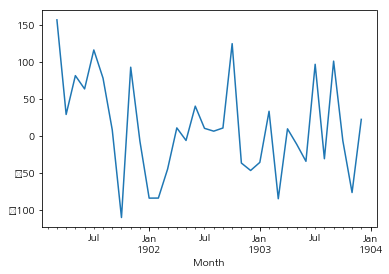

In [ ]:
results.resid.plot()

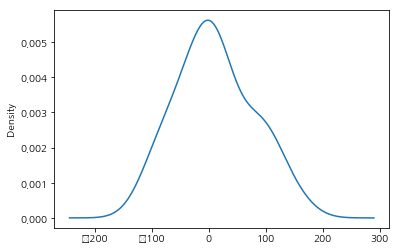

In [ ]:
results.resid.plot(kind='kde')

In [ ]:
results.resid.describe()

count     34.000000
mean      11.226048
std       66.730384
min     -110.457557
25%      -35.653924
50%        8.525816
75%       57.335824
max      156.402102
dtype: float64

## Rolling Forecast ARIMA Model

ARIMA 모델로 미래 데이터를 예측하기 위해 predict() 함수를 사용합니다. 이 함수는 파라메터로 예측할 타임스텝을(steps) 필요로하는데 학습 데이터에대한 인덱스 상대값을 입력하면 됩니다. 가령 모델을 학습하기 위해 100개의 학습데이터를 사용했다면 다음 스텝 예측값의 인덱스는 start=101, end=101 이 됩니다. 예측 결과 리턴값은 하나의 예측값을 포함한 배열이 됩니다.

또는 forcast() 함수로 파라메터 없이 다음 한 스템의 데이터를 예측할 수 있습니다. 

데이터를 train 과 test 로 나눈 뒤 train 데이터로 모델을 학습시키고 test 데이터의 각 시점에 해당하는 예측 해봅니다. 그러기 위해 새로운 actual value 를 하나씩 수집하면서 그와 함께 앞선 시점의 데이터로 ARIMA 모델을 학습과 예측을 반복하는 rolling forecast 를 수행하게 됩니다.

아래 코드에서 수동으로 관측값을을 history 변수에 추가해가면서 모델링과 예측을 반복하면서 prediction 과 expected value 를 출력하고 최종적으로 그에 따른 mean squared error (MSE) 를 계산합니다.

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = shampoo['Sales of shampoo'].values

# train , test 데이터를 2:1 로 split
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
# 학습시킬 데이터.   ##train data를 그대로 두기 위해 history란 이름의 똑같은 data를 만들어줌.
history = [x for x in train]
predictions = list()   ## list() 대신에 깔끔하게 [] 라고 해도된다.
# test 데이터만큼 모델링 & 예측
for t in range(len(test)):   ## 테스트 사이즈(len(test))만큼 돌려야 test와 prediction 결과를 비교할 수 있다.
    model = ARIMA(history, order=(4,2,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()  ## forecast()의 steps는 default값이 1.
    # predicted value
    yhat = output[0]        ## output결과가 list형태, 그 중 0번째가 predicted value.
    predictions.append(yhat)
    # actual value
    obs = test[t]
    # actual value 를 다음 스텝에서 학습할 데이터에 추가
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % sqrt(error))

predicted=399.145070, expected=342.300000
predicted=354.296547, expected=339.700000
predicted=429.967827, expected=440.400000
predicted=392.634721, expected=315.900000
predicted=420.191729, expected=439.300000
predicted=397.585477, expected=401.300000
predicted=487.892574, expected=437.400000
predicted=434.160097, expected=575.500000
predicted=467.057780, expected=407.600000
predicted=568.082676, expected=682.000000
predicted=468.024731, expected=475.300000
predicted=687.491687, expected=581.300000
predicted=617.839167, expected=646.900000
Test RMSE: 68.519


실제값(파란색)과 rolling forecast(red) 결과를 비교해보면 트렌드를 어느정도 예측하고 있음을 확인할 수 있습니다.

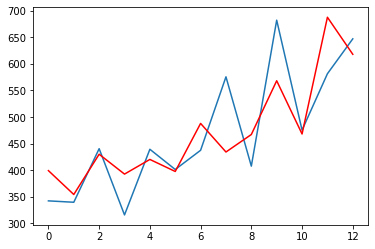

In [27]:
plt.plot(test)
plt.plot(predictions, color='red')